In [86]:
from settings import s, e
import numpy as np
import tensorflow as tf
import tensorflow.keras.backend as K
import pickle

from IPython.display import HTML, clear_output, display, update_display
import matplotlib.pyplot as plt


from simple import Game

from agent_code.tensor_agent.agent import TensorAgent
from agent_code.tensor_agent.hyperparameters import hp
from agent_code.tensor_agent.X import RelativeX2 as game_state_X

clear_output()

In [2]:
class Game:
    def __init__(self, coins, agents):
        self.shape = coins.shape
        self.agents = agents
        self.coins = coins
        self.steps = 0
        self.terminated = False
    
    @staticmethod
    def create_arena(shape, agent_names, coin_count=3):
        coins = np.zeros(shape)
        xs = np.random.choice(shape[0], coin_count)
        ys = np.random.choice(shape[1], coin_count)
        
        coins[xs, ys] = 1
        
        
        # Distribute starting positions
        xs = np.random.choice(shape[0], len(agent_names))
        ys = np.random.choice(shape[1], len(agent_names))
        agents = []
        for name in agent_names:
            x, y = np.random.choice(shape[0]), np.random.choice(shape[1])
            agents.append((x, y, name, 1, 0))
        
        return [coins, agents]
    
    def step(self, agent_actions, permutation=None):
        self.steps += 1

        if permutation is None:
            permutation = np.random.permutation(len(self.agents))

        step_score = {n: 0 for _,_,n,_,_ in self.agents}

        for j in range(len(self.agents)):
            agent = self.agents[permutation[j]]
            x, y, name, bombs_left, score = agent
            action = agent_actions[name]
            
            if action == 'DOWN' and self.tile_is_free(x, y+1):
                y += 1
            if action == 'UP' and self.tile_is_free(x, y-1):
                y -= 1
            if action == 'RIGHT' and self.tile_is_free(x+1, y):
                x += 1
            if action == 'LEFT' and self.tile_is_free(x-1, y):
                x -= 1
            
            self.agents[permutation[j]] = (x, y, name, bombs_left, score)
        
        
        for j in range(len(self.agents)):
            x, y, name, bombs_left, score = self.agents[j]
            if self.coins[x,y]==1:
                step_score[name]+=s.reward_coin
            self.coins[x,y]=0
        
        if np.all(self.coins == 0) or len(self.agents) == 0 or self.steps >= 10:
            self.terminated = True
        
        return step_score
    
    def get_X(self, x, y):
        X = np.zeros((self.shape[0] * 2 - 1, self.shape[1] * 2 - 1, 1))
        X[self.shape[0]-1-x:self.shape[0]*2-1-x, self.shape[1]-1-y:self.shape[1]*2-1-y, 0] = self.coins
        return X
        
    def tile_is_free(self, x, y):
        ax, ay = self.shape
        if x < 0 or x >= ax or y < 0 or y >= ay:
            return False
        return True
    

In [3]:
import numpy as np
import tensorflow as tf

import time
from copy import copy

from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, ZeroPadding2D, MaxPooling2D
from tensorflow.keras.models import Sequential, Model

from tensorflow.keras import backend as K

from agent_code.tensor_agent.hyperparameters import hp

from agent_code.tensor_agent.loss import weighted_huber_loss, huber_loss
from agent_code.tensor_agent.layers import NoisyDense, VAMerge


def create_conv_net(shape):
    # Convolutional part of the network
    inputs = Input(shape=shape)
    x = Flatten()(inputs)
    x = Dense(64, activation='relu')(x)
    outputs = Dense(64, activation='relu')(x)

    return inputs, outputs

def create_stream(x, D):
    
    s = NoisyDense(64, activation='relu')(x)
    s = NoisyDense(D, activation=None)(s)
    return s

def create_model(shape, D):
    # Create the convolutional network
    
    inputs, x = create_conv_net(shape=shape)
   
    # Dueling networks:
    # - Split the model into value stream and advantage stream
    v = create_stream(x, 1)
    a = create_stream(x, D)
    # - Merge streams
    outputs = VAMerge()([v, a])
    #outputs = Activation('relu')(outputs)

    model = Model(inputs=inputs, outputs=outputs)
    return model, inputs, outputs

class FullModel:
    def __init__(self, input_shape, D):
        self.input_shape = input_shape
        self.D = D

        #========================
        #  Define Model
        #========================

        # Define online and target models for Double Q-learning
        self.online, _, _ = create_model(input_shape, D)
        self.target, t_in, t_out = create_model(input_shape, D)

        
        #========================
        #  Define Training Update
        #========================
        action_holder = Input(shape=(1,), dtype='int32')  # in j=0,...,D-1
        reward_holder = Input(shape=(1,))
        weight_holder = Input(shape=(1,))
        
        # applies a mask to the outputs so that only the prediction for the chosen action is considered
        responsible_weight = tf.batch_gather(t_out, action_holder)
        
        loss = weighted_huber_loss(reward_holder, responsible_weight, weight_holder)
        tf.summary.scalar('loss', loss)
        tf.summary.scalar('reward', tf.reduce_mean(reward_holder))

        optimizer = tf.train.AdamOptimizer(hp.learning_rate, epsilon=hp.adam_epsilon)
        update = optimizer.minimize(loss)

        merged_summary = tf.summary.merge_all()

        self.summary = merged_summary
        self.train_writer = tf.summary.FileWriter(f'tf-board/train/{time.time()}',
                                      K.get_session().graph)
        
        self.errors=tf.abs(reward_holder-responsible_weight)
        self.input_ph = t_in
        self.t_out = t_out
        self.action_ph = action_holder
        self.reward_ph = reward_holder
        self.update_op = update
        self.weights = weight_holder

        self.steps = 0


    def update(self, inputs, actions, rewards, per_weights):
        sess = K.get_session()
        _, errors, summary = sess.run([self.update_op, self.errors, self.summary], feed_dict={
            self.input_ph: inputs,
            self.action_ph:actions,
            self.reward_ph:rewards,
            self.weights:per_weights
        })
        self.train_writer.add_summary(summary, self.steps)
        self.steps += 1
        return errors

    def update_online(self):
        self.online.set_weights(self.target.get_weights())

    def save(self, file='my_model.h5'):
        self.target.save(file)

    def load_weights(self, file='my_model.h5'):
        self.online.load_weights(file)
        self.target.load_weights(file)

    def clone(self, share_online=True):
        clone = copy(self)
        if not share_online:
            clone.online, _, _ = create_model(input_shape, D)

        return clone


In [4]:
hp.buffer_size = 4000
hp.target_network_period = 1000
hp.epsilon = 0.
hp.learning_rate=0.001

In [5]:
#from agent_code.tensor_agent.model import FullModel
choices = ['RIGHT', 'LEFT', 'UP', 'DOWN', 'BOMB', 'WAIT']
D = len(choices)
arena_shape = (4, 4)
input_shape = (arena_shape[0]*2-1, arena_shape[1]*2-1, 1)

K.clear_session()
model = FullModel(input_shape, D)

grads = tf.gradients(model.t_out, model.input_ph)

agents = {
    'tensor_agent': TensorAgent(input_shape, D, weights=None, model=model) # alt: weights='tensor_agent-model.h5'
}
train = {a: False for a in agents}
clear_output()

In [6]:

def get_valid_actions(x, y, game):
    # choices = ['RIGHT', 'LEFT', 'UP', 'DOWN', 'BOMB', 'WAIT']
    valid = np.ones((6))
    if not game.tile_is_free(x, y-1):
        valid[2] = 0 # UP invalid
    if not game.tile_is_free(x, y+1):
        valid[3] = 0 # DOWN invalid
    if not game.tile_is_free(x-1, y):
        valid[1] = 0 # LEFT invalid
    if not game.tile_is_free(x+1, y):
        valid[0] = 0 # RIGHT invalid

    valid[4] = 0
    valid[5] = 0
    return valid

In [7]:
d = display(f'Starting...', display_id='progress')

n_steps = 400000
game = None

train['tensor_agent'] = True
moving_reward = 0

for step in range(n_steps):
    if game is None:
        game = Game(*Game.create_arena(arena_shape, agents.keys(), coin_count=3))

    actions = {}
    Xs = {}
    for agent in game.agents:
        x, y, name, _, _ = agent
        
        Xs[name] = game.get_X(x, y)
        valid_actions = get_valid_actions(x, y, game)
        actions[name] = agents[name].act(Xs[name], train=train[name], valid_actions=valid_actions)
    
    actions_as_string = {n: choices[actions[n]] for n in actions.keys()}
    rewards = game.step(actions_as_string)
    moving_reward = 0.99 * moving_reward + rewards['tensor_agent']

    for _, _, name, _, _ in game.agents:
        if train[name]:
            agents[name].reward_update([Xs[name], actions[name], rewards[name]-0.1])
    
    if game.terminated:
        for name, a in agents.items():
            a.end_of_episode(save='tensor_agent-model.h5') # alt: save=None
        
        d.update(f'Step: {step+1}/{n_steps} Trained: {model.steps} Moving Reward: {moving_reward}')
        
        game = None

d.update(f'Complete')

'Step: 11909/400000 Trained: 1977 Moving Reward: 43.98271508187177'

End of episode. Steps: 10. Trained: 0
End of episode. Steps: 20. Trained: 0
End of episode. Steps: 30. Trained: 0
End of episode. Steps: 40. Trained: 0
End of episode. Steps: 50. Trained: 0
End of episode. Steps: 60. Trained: 0
End of episode. Steps: 70. Trained: 0
End of episode. Steps: 80. Trained: 0
End of episode. Steps: 90. Trained: 0
End of episode. Steps: 100. Trained: 0
End of episode. Steps: 110. Trained: 0
End of episode. Steps: 120. Trained: 0
End of episode. Steps: 130. Trained: 0
End of episode. Steps: 140. Trained: 0
End of episode. Steps: 150. Trained: 0
End of episode. Steps: 160. Trained: 0
End of episode. Steps: 170. Trained: 0
End of episode. Steps: 180. Trained: 0
End of episode. Steps: 190. Trained: 0
End of episode. Steps: 200. Trained: 0
End of episode. Steps: 210. Trained: 0
End of episode. Steps: 220. Trained: 0
End of episode. Steps: 230. Trained: 0
End of episode. Steps: 240. Trained: 0
End of episode. Steps: 250. Trained: 0
End of episode. Steps: 260. Traine

End of episode. Steps: 2056. Trained: 0
End of episode. Steps: 2066. Trained: 0
End of episode. Steps: 2076. Trained: 0
End of episode. Steps: 2086. Trained: 0
End of episode. Steps: 2096. Trained: 0
End of episode. Steps: 2106. Trained: 0
End of episode. Steps: 2116. Trained: 0
End of episode. Steps: 2126. Trained: 0
End of episode. Steps: 2136. Trained: 0
End of episode. Steps: 2146. Trained: 0
End of episode. Steps: 2156. Trained: 0
End of episode. Steps: 2166. Trained: 0
End of episode. Steps: 2176. Trained: 0
End of episode. Steps: 2186. Trained: 0
End of episode. Steps: 2196. Trained: 0
End of episode. Steps: 2206. Trained: 0
End of episode. Steps: 2212. Trained: 0
End of episode. Steps: 2216. Trained: 0
End of episode. Steps: 2226. Trained: 0
End of episode. Steps: 2236. Trained: 0
End of episode. Steps: 2246. Trained: 0
End of episode. Steps: 2256. Trained: 0
End of episode. Steps: 2266. Trained: 0
End of episode. Steps: 2276. Trained: 0
End of episode. Steps: 2286. Trained: 0


End of episode. Steps: 4061. Trained: 15
End of episode. Steps: 4071. Trained: 17
End of episode. Steps: 4081. Trained: 20
End of episode. Steps: 4091. Trained: 22
End of episode. Steps: 4101. Trained: 25
End of episode. Steps: 4111. Trained: 27
End of episode. Steps: 4121. Trained: 30
End of episode. Steps: 4131. Trained: 32
End of episode. Steps: 4141. Trained: 35
End of episode. Steps: 4151. Trained: 37
End of episode. Steps: 4161. Trained: 40
End of episode. Steps: 4171. Trained: 42
End of episode. Steps: 4181. Trained: 45
End of episode. Steps: 4191. Trained: 47
End of episode. Steps: 4201. Trained: 50
End of episode. Steps: 4211. Trained: 52
End of episode. Steps: 4221. Trained: 55
End of episode. Steps: 4231. Trained: 57
End of episode. Steps: 4241. Trained: 60
End of episode. Steps: 4251. Trained: 62
End of episode. Steps: 4261. Trained: 65
End of episode. Steps: 4271. Trained: 67
End of episode. Steps: 4281. Trained: 70
End of episode. Steps: 4291. Trained: 72
End of episode. 

End of episode. Steps: 5753. Trained: 438
End of episode. Steps: 5757. Trained: 439
End of episode. Steps: 5767. Trained: 441
End of episode. Steps: 5777. Trained: 444
End of episode. Steps: 5784. Trained: 446
End of episode. Steps: 5789. Trained: 447
End of episode. Steps: 5799. Trained: 449
End of episode. Steps: 5804. Trained: 451
End of episode. Steps: 5814. Trained: 453
End of episode. Steps: 5817. Trained: 454
End of episode. Steps: 5822. Trained: 455
End of episode. Steps: 5825. Trained: 456
End of episode. Steps: 5835. Trained: 458
End of episode. Steps: 5845. Trained: 461
End of episode. Steps: 5855. Trained: 463
End of episode. Steps: 5865. Trained: 466
End of episode. Steps: 5875. Trained: 468
End of episode. Steps: 5878. Trained: 469
End of episode. Steps: 5887. Trained: 471
End of episode. Steps: 5891. Trained: 472
End of episode. Steps: 5901. Trained: 475
End of episode. Steps: 5910. Trained: 477
End of episode. Steps: 5913. Trained: 478
End of episode. Steps: 5923. Train

End of episode. Steps: 7102. Trained: 775
End of episode. Steps: 7109. Trained: 777
End of episode. Steps: 7112. Trained: 778
End of episode. Steps: 7115. Trained: 778
End of episode. Steps: 7122. Trained: 780
End of episode. Steps: 7126. Trained: 781
End of episode. Steps: 7131. Trained: 782
End of episode. Steps: 7137. Trained: 784
End of episode. Steps: 7145. Trained: 786
End of episode. Steps: 7149. Trained: 787
End of episode. Steps: 7155. Trained: 788
End of episode. Steps: 7161. Trained: 790
End of episode. Steps: 7171. Trained: 792
End of episode. Steps: 7179. Trained: 794
End of episode. Steps: 7184. Trained: 796
End of episode. Steps: 7188. Trained: 797
End of episode. Steps: 7194. Trained: 798
End of episode. Steps: 7199. Trained: 799
End of episode. Steps: 7208. Trained: 802
End of episode. Steps: 7213. Trained: 803
End of episode. Steps: 7221. Trained: 805
End of episode. Steps: 7226. Trained: 806
End of episode. Steps: 7234. Trained: 808
End of episode. Steps: 7242. Train

End of episode. Steps: 8324. Trained: 1081
End of episode. Steps: 8332. Trained: 1083
End of episode. Steps: 8340. Trained: 1085
End of episode. Steps: 8344. Trained: 1086
End of episode. Steps: 8351. Trained: 1087
End of episode. Steps: 8354. Trained: 1088
End of episode. Steps: 8361. Trained: 1090
End of episode. Steps: 8370. Trained: 1092
End of episode. Steps: 8377. Trained: 1094
End of episode. Steps: 8380. Trained: 1095
End of episode. Steps: 8386. Trained: 1096
End of episode. Steps: 8393. Trained: 1098
End of episode. Steps: 8399. Trained: 1099
End of episode. Steps: 8403. Trained: 1100
End of episode. Steps: 8412. Trained: 1103
End of episode. Steps: 8416. Trained: 1104
End of episode. Steps: 8426. Trained: 1106
End of episode. Steps: 8434. Trained: 1108
End of episode. Steps: 8438. Trained: 1109
End of episode. Steps: 8444. Trained: 1111
End of episode. Steps: 8451. Trained: 1112
End of episode. Steps: 8459. Trained: 1114
End of episode. Steps: 8466. Trained: 1116
End of epis

End of episode. Steps: 9520. Trained: 1380
End of episode. Steps: 9525. Trained: 1381
End of episode. Steps: 9531. Trained: 1382
End of episode. Steps: 9541. Trained: 1385
End of episode. Steps: 9547. Trained: 1386
End of episode. Steps: 9549. Trained: 1387
End of episode. Steps: 9555. Trained: 1388
End of episode. Steps: 9565. Trained: 1391
End of episode. Steps: 9571. Trained: 1392
End of episode. Steps: 9577. Trained: 1394
End of episode. Steps: 9585. Trained: 1396
End of episode. Steps: 9592. Trained: 1398
End of episode. Steps: 9597. Trained: 1399
End of episode. Steps: 9602. Trained: 1400
End of episode. Steps: 9609. Trained: 1402
End of episode. Steps: 9615. Trained: 1403
End of episode. Steps: 9622. Trained: 1405
End of episode. Steps: 9628. Trained: 1407
End of episode. Steps: 9633. Trained: 1408
End of episode. Steps: 9639. Trained: 1409
End of episode. Steps: 9648. Trained: 1412
End of episode. Steps: 9657. Trained: 1414
End of episode. Steps: 9663. Trained: 1415
End of epis

End of episode. Steps: 10706. Trained: 1676
End of episode. Steps: 10711. Trained: 1677
End of episode. Steps: 10716. Trained: 1679
End of episode. Steps: 10722. Trained: 1680
End of episode. Steps: 10730. Trained: 1682
End of episode. Steps: 10737. Trained: 1684
End of episode. Steps: 10746. Trained: 1686
End of episode. Steps: 10753. Trained: 1688
End of episode. Steps: 10761. Trained: 1690
End of episode. Steps: 10768. Trained: 1692
End of episode. Steps: 10773. Trained: 1693
End of episode. Steps: 10778. Trained: 1694
End of episode. Steps: 10787. Trained: 1696
End of episode. Steps: 10794. Trained: 1698
End of episode. Steps: 10800. Trained: 1700
End of episode. Steps: 10810. Trained: 1702
End of episode. Steps: 10815. Trained: 1703
End of episode. Steps: 10820. Trained: 1705
End of episode. Steps: 10826. Trained: 1706
End of episode. Steps: 10834. Trained: 1708
End of episode. Steps: 10843. Trained: 1710
End of episode. Steps: 10853. Trained: 1713
End of episode. Steps: 10858. Tr

End of episode. Steps: 11880. Trained: 1970
End of episode. Steps: 11888. Trained: 1972
End of episode. Steps: 11894. Trained: 1973
End of episode. Steps: 11902. Trained: 1975
End of episode. Steps: 11909. Trained: 1977


KeyboardInterrupt: 

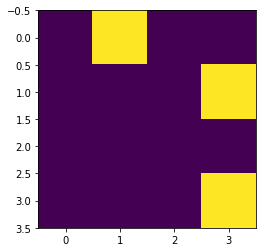

In [62]:
game = Game(*Game.create_arena(arena_shape, agents.keys(), coin_count=3))
plt.imshow(game.coins)
imgs = []

0 1
[ 0.05233169 -0.03814147 -0.01343612 -0.05006592 -0.19509315 -0.00812619]
[1.24742484 0.         1.18165708 1.14502728 0.         0.        ]
RIGHT {'tensor_agent': 0}


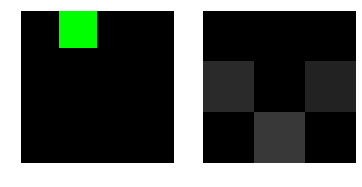

In [71]:
actions = {}
Xs = {}
c = np.copy(game.coins)
for agent in game.agents:
    x, y, name, _, _ = agent

    Xs[name] = game.get_X(x, y)
    valid_actions = get_valid_actions(x, y, game)
    
    print(x, y)
    pred = agents[name].model.online.predict(np.array([Xs[name]]))[0]
    print(pred)
    if valid_actions is not None:
        pred = valid_actions * (pred - np.min(pred) + 1)

    print(pred)
    action_choice = np.argmax(pred)
            
    actions[name] = action_choice

actions_as_string = {n: choices[actions[n]] for n in actions.keys()}
#actions_as_string['tensor_agent'] = 'RIGHT'
rewards = game.step(actions_as_string)

print(actions_as_string['tensor_agent'], rewards)

#img = np.zeros((input_shape[0], input_shape[1], 3))
#img[:,:,0] = Xs['tensor_agent'][:,:,0]
#img[arena_shape[0]-1,arena_shape[1]-1,1] = 1

img = np.zeros((arena_shape[0], arena_shape[0], 3))
img[:,:,0] = c
img[x,y,1] = 1


choices = ['RIGHT', 'LEFT', 'UP', 'DOWN', 'BOMB', 'WAIT']
choice_dict = {choices[i]: i for i in range(len(choices))}

a = np.zeros((3, 3))
a[2, 1] = pred[choice_dict['RIGHT']]
a[0, 1] = pred[choice_dict['LEFT']]
a[1, 0] = pred[choice_dict['UP']]
a[1, 2] = pred[choice_dict['DOWN']]
a[1, 1] = pred[choice_dict['WAIT']]
a[0, 0] = pred[choice_dict['BOMB']]

#a = np.exp(a) / np.sum(np.exp(a), axis=0)
a = np.log(a + 0.0001)
a[a == -np.inf] = 0

f, (ax1, ax2) = plt.subplots(1, 2)

ax1.axis('off')
ax2.axis('off')
ax2.imshow(a, cmap='gray', vmin=0, vmax=1)
ax1.imshow(img)
imgs.append(img)

In [56]:
game.agents[0] = (0,2,'tensor_agent',1,0)

In [87]:

def animation(imgs, r, c, steps, interval=50):
    import matplotlib.animation
    
    fig = plt.gcf()
    plt.axis('off')

    def animate(t):
        plt.imshow(imgs[t])

    ani = matplotlib.animation.FuncAnimation(fig, animate, frames=steps, interval=interval)
    return ani

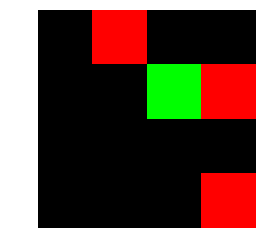

In [89]:
r,c,steps = 1,2,len(imgs)  # number of rows, columns and steps to walk in latent space
anim = animation(imgs,r,c,steps, interval=300)
HTML(anim.to_jshtml())

In [8]:
pred, grd = K.get_session().run([model.t_out, grads], feed_dict={
            model.input_ph: np.array([Xs['tensor_agent']])
        })

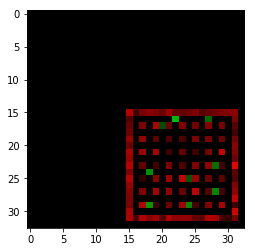

In [21]:
img0 = grd[0][0][:,:,0:1]
img0 = img0 - np.min(img0)
img0 = img0 / np.max(img0)

img1 = grd[0][0][:,:,1:2]
img1 = img1 - np.min(img1)
img1 = img1 / np.max(img1)

img5 = grd[0][0][:,:,5:6]
img5 = img5 - np.min(img5)
img5 = img5 / np.max(img5)

inp = Xs['tensor_agent'][:,:,[0,5,1]]
img = np.concatenate([img0, img5, img1], axis=2)


plt.imshow(img * inp)

In [6]:
class FrozenLake:
    def __init__(self, coins, agents):
        self.shape = coins.shape
        self.agents = agents
        self.coins = coins
        self.steps = 0
        self.terminated = False
    
    @staticmethod
    def create_arena(shape, agent_names):
        lake = np.zeros(shape)
        xs = np.random.choice(shape[0], 1)
        ys = np.random.choice(shape[1], 1)
        
        lake[xs, ys] = 1
        
        while np.min(lake) > -1:
            xs = np.random.choice(shape[0], 1)
            ys = np.random.choice(shape[1], 1)
            if lake[xs, ys] != 1:
                lake[xs, ys] = -1
        
        
        # Distribute starting positions
        xs = np.random.choice(shape[0], len(agent_names))
        ys = np.random.choice(shape[1], len(agent_names))
        agents = []
        for name in agent_names:
            x, y = np.random.choice(shape[0]), np.random.choice(shape[1])
            agents.append((x, y, name, 1, 0))
        
        return [lake, agents]
    
    def step(self, agent_actions, permutation=None):
        self.steps += 1

        if permutation is None:
            permutation = np.random.permutation(len(self.agents))

        step_score = {n: 0 for _,_,n,_,_ in self.agents}

        for j in range(len(self.agents)):
            agent = self.agents[permutation[j]]
            x, y, name, bombs_left, score = agent
            action = agent_actions[name]
            
            if action == 'DOWN' and self.tile_is_free(x, y+1):
                y += 1
            if action == 'UP' and self.tile_is_free(x, y-1):
                y -= 1
            if action == 'RIGHT' and self.tile_is_free(x+1, y):
                x += 1
            if action == 'LEFT' and self.tile_is_free(x-1, y):
                x -= 1
            
            self.agents[permutation[j]] = (x, y, name, bombs_left, score)
        
        
        for j in range(len(self.agents)):
            x, y, name, bombs_left, score = self.agents[j]
            if self.coins[x,y]==1:
                step_score[name]+=s.reward_coin
            self.coins[x,y]=0
        
        if np.all(self.coins == 0) or len(self.agents) == 0 or self.steps >= 40:
            self.terminated = True
        
        return step_score
    
    def get_X(self, x, y):
        X = np.zeros((self.shape[0] * 2 - 1, self.shape[1] * 2 - 1, 1))
        X[self.shape[0]-1-x:self.shape[0]*2-1-x, self.shape[1]-1-y:self.shape[1]*2-1-y, 0] = self.coins
        return X
        
    def tile_is_free(self, x, y):
        ax, ay = self.shape
        if x < 0 or x >= ax or y < 0 or y >= ay:
            return False
        return True
    